## Load Libs

In [1]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from matplotlib import pyplot as plt
sns.set(style="white")

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Activation, Input, Dropout, Embedding, Flatten, Input
from keras.layers import Concatenate
from keras.optimizers import Adam, Nadam
from keras import regularizers

%matplotlib inline

def plot_result(hist):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['acc'], label='acc')
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.title('Accuracy')

    plt.legend(loc='best')
    plt.show()
    
def draw_roc_curve(y, pred):
    from matplotlib import pyplot as plt

    fprRf, tprRf, _ = roc_curve(y, pred, pos_label=1)
    auc_scr = auc(fprRf, tprRf)
    print("auc:", auc_scr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Area Under Curve(ROC) (score: {:.4f})'.format(auc_scr))
    ax.legend(loc='best')
    plt.show()

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


Using TensorFlow backend.


## Data Schema

Column name     | Description
             ---|---
RorNumber       |    Row number
CustomerId      |    Customer id
Surname         |    Customer surname
CreditScore     |    Credit score
Geography       |    Country the customer belong to
Gender          |    Female or Male
Age             |    Customer's age
Tenure          |    Life length of customer
Balance         |    Bank balance of the customer
NumOfProducts   |    Number of product belong to the customer
HasCrCard       |    If customer has credit card
IsActiveMember  |    If customer status is active or disabled
EstimatedSalary |    Estimated salary for the customer
Exited                   |    Label, 1: Churn, 0: Not Churn

---

* 7個類別變數
* 6個數值變數
---



## Purpose: 
* 給定客戶Metadata, 繳費行為等等, 預測該客戶是否在未來有可能離開?

In [2]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_financial_churn.csv")
raw_vl = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_vl_financial_churn.csv")
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


## Drop 不必要的欄位

In [0]:
raw.drop(['RowNumber', 'CustomerId', 'Surname'], 1, inplace=True)
raw_vl.drop(['RowNumber', 'CustomerId', 'Surname'], 1, inplace=True)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
CreditScore        7500 non-null int64
Geography          7500 non-null object
Gender             7500 non-null object
Age                7500 non-null int64
Tenure             7500 non-null int64
Balance            7500 non-null float64
NumOfProducts      7500 non-null int64
HasCrCard          7500 non-null int64
IsActiveMember     7500 non-null int64
EstimatedSalary    7500 non-null float64
Exited             7500 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 644.6+ KB


## Features setting

In [0]:
catg_features = [
    'Gender', 'HasCrCard', 'IsActiveMember', 'Geography', 
]
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# embedding_features = catg_features + ['binn_tenure', 'binn_MonthlyCharges', 'binn_TotalCharges']
label = 'Exited'

<br/>

---



## Base Feature Preprocessing

* Normalize ofr numeric features
* One Hot Encoding for categorical features

In [0]:
def feature_engineering(raw, is_train=True, status=None):
    data = raw.copy()
    
    if is_train:
        status = {'scaler': None, 
                  'mapper': defaultdict(LabelBinarizer),
                  'woe_mapper': {},
                  'binn_mapper': {},
                  'freq_mapper': {},
                  'mean_mapper': {}}

    catg_ftrs = catg_features.copy()
        
    # Numeric binning to categorical features
    do_binning(catg_ftrs, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    catg_part = pd.DataFrame()
    
    # One Hot Encoding
    # catg_part = pd.get_dummies(data[catg_ftrs])
    do_onehot(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Embedding, simple indexing categorical features, actual embedding function in keras
    # do_embedding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # WOE encoding
    do_woe_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Frequency encoding, target mean encoding
    do_target_encoding(catg_ftrs, catg_part, status, data, is_train)
    # -----------------------------------------------------------------------------------------

    # Normalize
    num_part = do_norm(num_features, status, data, is_train)
    # -----------------------------------------------------------------------------------------
    
    # Merge categorical, numeric features
    data_x, data_y = pd.concat([catg_part, num_part], 1), data['Exited'].copy()
    
    # Include quadratic term, cube term
    do_nth_order_polynominal(num_features, data_x)
    # ----------------------------------------------------------------------------------------- 
    return data_x, data_y, status


## Functions of Features Processing

In [0]:
def do_binning(catg_ftrs, status, data, is_train):
    pass

def do_onehot(catg_ftrs, catg_part, status, data, is_train):
    mapper = status['mapper']
    tmp = []
    for catg_col in catg_ftrs:
        if is_train:
            result = mapper[catg_col].fit_transform(data[catg_col])
        else:
            result = mapper[catg_col].transform(data[catg_col])

        columns = [f'{catg_col}_{col}' for col in mapper[catg_col].classes_]
        if result.shape[1] == 1:
            columns = columns[:1]
        tmp.append(pd.DataFrame(data=result, columns=columns))
    tmp = pd.concat(tmp, 1)
    for col in tmp:
        catg_part[col] = tmp[col]
    pass

def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train):
    pass

def do_target_encoding(catg_ftrs, catg_part, status, data, is_train):
    pass

def do_norm(num_features, status, data, is_train):
    num_part = data[num_features].copy()
    if is_train:
        scaler = StandardScaler()
        status['scaler'] = scaler
        num_part = pd.DataFrame(data=scaler.fit_transform(num_part), columns=num_part.columns)
    else:
        scaler = status['scaler']
        num_part = pd.DataFrame(data=scaler.transform(num_part), columns=num_part.columns)
    return num_part
    pass

def do_nth_order_polynominal(num_features, data):
    pass

In [8]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(7500, 12) (2500, 12)


,Gender_Female,HasCrCard_0,IsActiveMember_0,Geography_France,Geography_Germany,Geography_Spain,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,0,1,0,0,1,0,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,0,1,1,1,0,0,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,1,1,0,0,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,1,0,1,0,0,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,1,0,0,1,0,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model on Base Featue Engineering

* Network Structure: 
    * `dimension of input, 6, 6, 1`
* ReLU Activation Function
* Adam Optimizer
* Sigmoid Cross Entropy

In [0]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 6, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 6, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 47us/step - loss: 0.6774 - acc: 0.7865 - val_loss: 0.6504 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.5985 - acc: 0.7936 - val_loss: 0.5216 - val_acc: 0.8044
Epoch 3/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.4865 - acc:

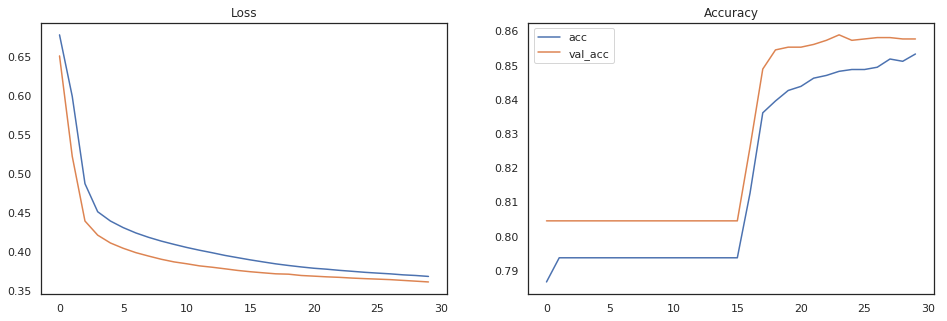

auc: 0.8484205987721927


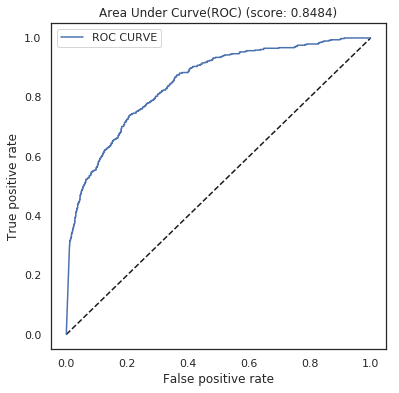

In [10]:
K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

## Analyze the Prediction

In [11]:
y_pred = model.predict(vl_x)
y_pred

array([[0.09069794],
       [0.10945781],
       [0.11801213],
       ...,
       [0.29696214],
       [0.14731905],
       [0.01241212]], dtype=float32)

count    2500.000000
mean        0.182464
std         0.180214
min         0.002498
25%         0.038213
50%         0.110437
75%         0.286942
max         0.580316
dtype: float64
0.18246396 0.18021429


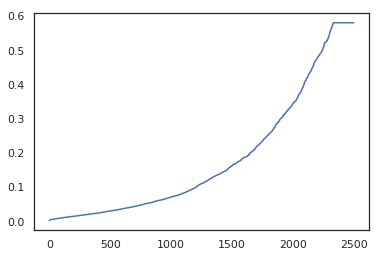

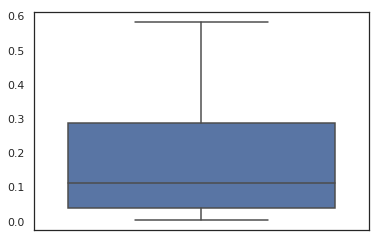

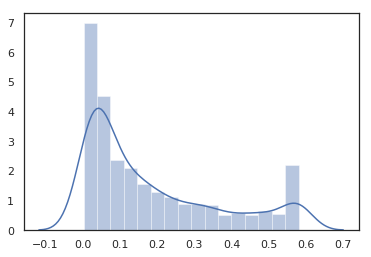

In [12]:
def pred_dist(y_pred):
    y_pred = pd.Series(y_pred.ravel())
    print( y_pred.describe() )
    print( y_pred.mean(), y_pred.std() )
    sns.lineplot(range(len(y_pred)), sorted(y_pred.ravel()))
    plt.show()

    sns.boxplot(y_pred.ravel(), orient='v')
    plt.show()

    sns.distplot(y_pred.ravel())
    plt.show()
    
pred_dist(y_pred)

## Observation

* 預測結果介於0 ~ 0.6之間
* 問題變成找出最佳Threshold ==> 預測機率大於多少時認為是`Exited = 1`

---


## 找出最佳閥值

In [13]:
# 依照所有的閥值(切割100等分)算出F score, 找出分數最高的閥值
def f_beta_scann(y_true, y_pred, beta=0.5):
    y_pred = pd.Series(y_pred.ravel())
    # 切割100等分, 尋找最佳 f beta score
    bins = np.linspace(y_pred.min(), y_pred.max(), 100)
    # 找出F beta score最高的點
    result = np.array([precision_recall_fscore_support(y_true=y_true, y_pred=y_pred > thres, beta=beta)[2][1] 
                       for thres in bins])
    best_idx = result.argmax()
    return bins[best_idx], result[best_idx]

def analyze(y_true, y_pred):
    thres, f_beta = f_beta_scann(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred.ravel() > thres)
    print(f'thres: {thres:.4f}, f_beta score: {f_beta:.4f}')
    print(f'accuracy@{thres:.4f}: {acc:.2f}\n')

    print(f'threshold@0.5, accuracy: {accuracy_score(y_true, y_pred.ravel() > 0.5):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > 0.5), '\n')

    print(f'threshold@{thres:.4f}, accuracy: {accuracy_score(y_true, y_pred.ravel() > thres):.4f}')
    print(confusion_matrix(y_true, y_pred.ravel() > thres))
    
analyze(vl_y, y_pred)

thres: 0.4928, f_beta score: 0.6487
accuracy@0.4928: 0.86

threshold@0.5, accuracy: 0.8576
[[1948   63]
 [ 293  196]] 

threshold@0.4928, accuracy: 0.8592
[[1946   65]
 [ 287  202]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Observation

* 同樣的預測結果, 決定不同的threshold能夠找到更好的結果

## Bining Numeric Feature

* Quartile cut
* `Age`欄位特殊處理 => [14, 30, 35, 40, 45, 62]
* `Balance`欄位特殊處理 => `IsBalanceZero`


In [0]:
def do_binning(catg_ftrs, status, data, is_train):
    # Quartile binning, outlier set to class "0"
    def quartile_binning(x):
        bins = np.percentile(x, range(0, 100, 25))[1:].tolist()
        iqr_x_150 = (bins[-1] - bins[0]) * 1.5
        bins = [bins[0] - iqr_x_150] + bins + [bins[-1] + iqr_x_150]
        result = pd.Series(np.digitize(x, bins)).map(pd.Series([0, 1, 2, 3, 4, 0])).values
        return result, bins
    
    # Age
    bins = np.array([14, 30, 35, 40, 45, 62])
    labels = ['~14', '14-30', '30-35', '35-40', '40-45', '45-62', '62up']
    age_map = pd.Series(labels)
    data['binn_Age'] = pd.Series(np.digitize(data.Age, bins)).map(age_map).values
    catg_ftrs.append('binn_Age')
    # Balance
    data['binn_Balance'] = data.Balance.map(lambda e: 0 if e == 0 else 1)
    catg_ftrs.append('binn_Balance')
    
    for col in ('CreditScore', 'Tenure', 'EstimatedSalary'):
        binned_name = f'binn_{col}'
        if is_train:
            result, bins = quartile_binning(data[col])
            status['binn_mapper'][binned_name] = bins
            data[binned_name] = result
        else:
            bins = status['binn_mapper'][binned_name]
            data[binned_name] = pd.Series(np.digitize(data[col], bins))\
                                  .map(pd.Series([0, 1, 2, 3, 4, 0])).values

        catg_ftrs.append(binned_name)
    pass

In [15]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(7500, 32) (2500, 32)


,Gender_Female,HasCrCard_0,IsActiveMember_0,Geography_France,Geography_Germany,Geography_Spain,binn_Age_14-30,binn_Age_30-35,binn_Age_35-40,binn_Age_40-45,...,binn_EstimatedSalary_1,binn_EstimatedSalary_2,binn_EstimatedSalary_3,binn_EstimatedSalary_4,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,0,1,1,1,0,0,0,0,0,0,...,1,0,0,0,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,1,0,0,1,0,0,0,0,1,...,1,0,0,0,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model (Binning)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 47us/step - loss: 0.5903 - acc: 0.7904 - val_loss: 0.4427 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 21us/step - loss: 0.4427 - acc: 0.7936 - val_loss: 0.4050 - val_acc: 0.8044
Epoch 3/30
7500/7500 [==============================] - 0s 21us/step - loss: 0.4257 - 

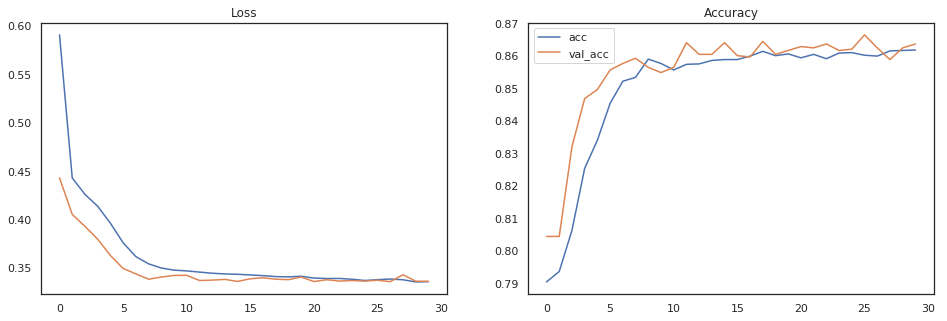

auc: 0.8563229436463459


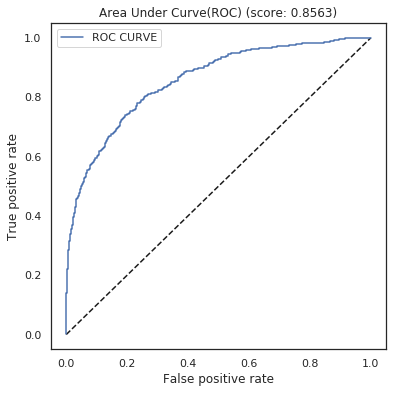

count    2500.000000
mean        0.192227
std         0.238840
min         0.002716
25%         0.032463
50%         0.090342
75%         0.251239
max         0.999876
dtype: float64
0.19222715 0.2388404


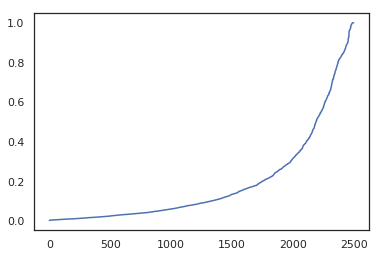

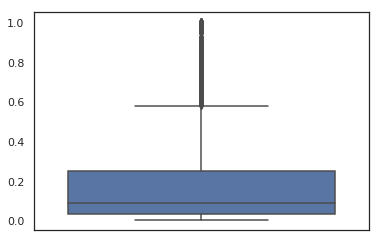

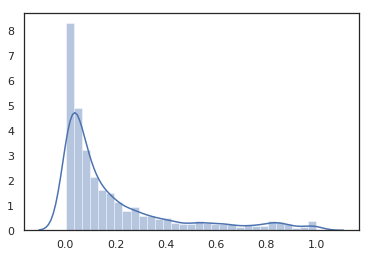

thres: 0.5265, f_beta score: 0.6762
accuracy@0.5265: 0.87

threshold@0.5, accuracy: 0.8636
[[1930   81]
 [ 260  229]] 

threshold@0.5265, accuracy: 0.8668
[[1944   67]
 [ 266  223]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Add Weight of Evidence Encoding

In [0]:
def do_woe_encoding(catg_ftrs, catg_part, status, data, is_train):

    def woe_encode(x, label, data):
        """Calculate the Weight of Evidence of given categorical feature and label

        :param x: Given feature name
        :param label: Label name
        :param data:
        :return: WOE encoded dictionary
        """
        total_vc = data[label].value_counts().sort_index()

        def woe(pipe, total_vc):
            # Count by label in this group
            group_vc = pipe[label].value_counts().sort_index()

            # Some class in the feature is missing, fill zero to missing class
            if len(group_vc) < len(total_vc):
                for key in total_vc.index:
                    if key not in group_vc:
                        group_vc[key] = 0.
                group_vc = group_vc.sort_index()

            # WOE formula
            r = ((group_vc + 0.5) / total_vc).values

            # Odd ratio => 1 to 0, you can define meaning of each class
            return np.log(r[1] / r[0])

        return data.groupby(x).apply(lambda pipe: woe(pipe, total_vc))

    for catg_col in catg_ftrs:
        if is_train:
            kv = woe_encode(catg_col, 'Exited', data)
            status['woe_mapper'][catg_col] = kv.to_dict()
        else:
            kv = pd.Series(status['woe_mapper'][catg_col])
        catg_part[f'woe_{catg_col}'] = kv.reindex(data[catg_col]).values
    pass

In [18]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(7500, 41) (2500, 41)


,Gender_Female,HasCrCard_0,IsActiveMember_0,Geography_France,Geography_Germany,Geography_Spain,binn_Age_14-30,binn_Age_30-35,binn_Age_35-40,binn_Age_40-45,...,woe_binn_Balance,woe_binn_CreditScore,woe_binn_Tenure,woe_binn_EstimatedSalary,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,0,1,0,0,1,0,0,0,1,0,...,0.206449,0.004414,0.147695,-0.005562,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,0,1,1,1,0,0,0,0,0,0,...,-0.439217,0.028947,0.147695,-0.058630,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,1,1,0,0,0,0,0,0,...,-0.439217,-0.128854,-0.032175,-0.005562,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,1,0,1,0,0,0,0,0,1,...,-0.439217,0.004414,-0.057250,-0.058630,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,1,0,0,1,0,0,0,0,1,...,0.206449,0.028947,-0.057250,-0.058630,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model (WOE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2688      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 52us/step - loss: 0.5536 - acc: 0.7873 - val_loss: 0.4022 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 22us/step - loss: 0.4228 - acc: 0.8136 - val_loss: 0.3856 - val_acc: 0.8444
Epoch 3/30
7500/7500 [==============================] - 0s 22us/step - loss: 0.4125 - 

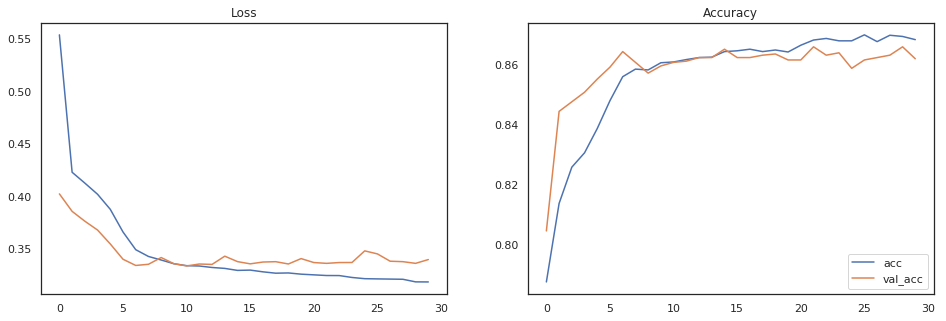

auc: 0.8539149198833818


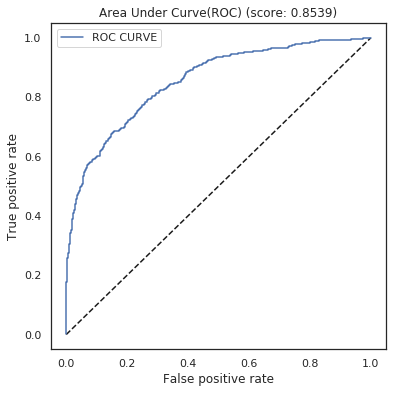

count    2500.000000
mean        0.209343
std         0.258939
min         0.002083
25%         0.032159
50%         0.092231
75%         0.277019
max         0.999973
dtype: float64
0.20934325 0.25893936


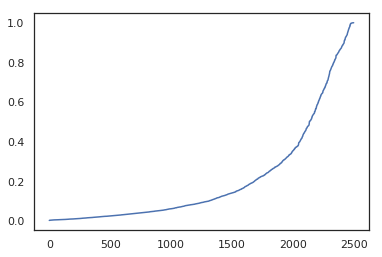

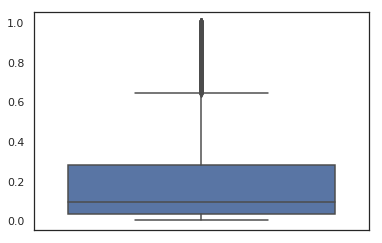

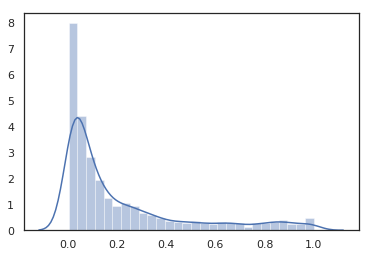

thres: 0.6371, f_beta score: 0.6808
accuracy@0.6371: 0.87

threshold@0.5, accuracy: 0.8620
[[1901  110]
 [ 235  254]] 

threshold@0.6371, accuracy: 0.8672
[[1956   55]
 [ 277  212]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Statistical Encoding, Target Encoding

* Frequency encoding
* Mean encoding

In [0]:
def do_target_encoding(catg_ftrs, catg_part, status, data, is_train):
    for catg_col in catg_ftrs:
        if is_train:
            freq_proportion = data[catg_col].value_counts() / len(data)
            catg_part[f'freq_{catg_col}'] = freq_proportion.reindex(data[catg_col]).values
            target_mean = data.groupby(catg_col).Exited.mean()
            catg_part[f'mean_{catg_col}'] = target_mean.reindex(data[catg_col]).values

            status['freq_mapper'][catg_col] = freq_proportion.to_dict()
            status['mean_mapper'][catg_col] = target_mean.to_dict()
        else:
            catg_part[f'freq_{catg_col}'] = pd.Series(status['freq_mapper'][catg_col]).reindex(data[catg_col]).values
            catg_part[f'mean_{catg_col}'] = pd.Series(status['mean_mapper'][catg_col]).reindex(data[catg_col]).values
    pass

In [21]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(7500, 59) (2500, 59)


,Gender_Female,HasCrCard_0,IsActiveMember_0,Geography_France,Geography_Germany,Geography_Spain,binn_Age_14-30,binn_Age_30-35,binn_Age_35-40,binn_Age_40-45,...,freq_binn_Tenure,mean_binn_Tenure,freq_binn_EstimatedSalary,mean_binn_EstimatedSalary,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,0,1,0,0,1,0,0,0,1,0,...,0.146933,0.231397,0.25,0.205333,0.931808,-0.286140,-1.726890,0.818951,0.804202,-0.449945
1,0,1,1,1,0,0,0,0,0,0,...,0.146933,0.231397,0.25,0.196800,-0.185926,0.761549,-1.726890,-1.223103,-0.913689,-1.631281
2,1,1,1,1,0,0,0,0,0,0,...,0.305067,0.201049,0.25,0.205333,0.176303,3.142658,-1.036539,-1.223103,0.804202,-0.510415
3,1,1,0,1,0,0,0,0,0,1,...,0.297733,0.197044,0.25,0.196800,0.797266,0.380571,0.689338,-1.223103,0.804202,-1.045445
4,1,1,0,0,1,0,0,0,0,1,...,0.297733,0.197044,0.25,0.196800,-0.320468,0.094838,-0.001013,0.507413,0.804202,-0.876750


## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3840      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 62us/step - loss: 0.5682 - acc: 0.7877 - val_loss: 0.4135 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 24us/step - loss: 0.4258 - acc

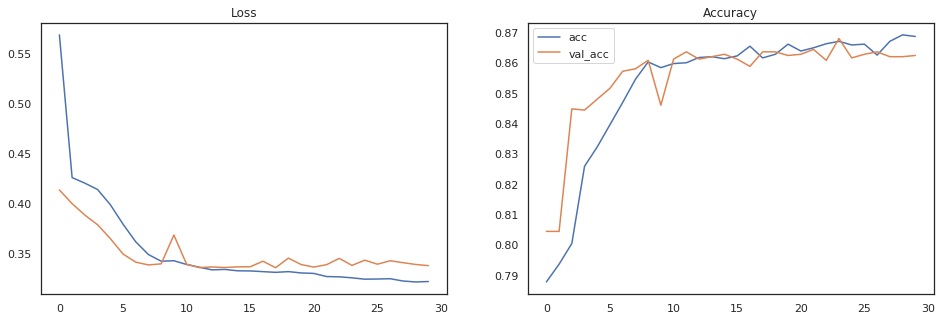

auc: 0.8543013426156141


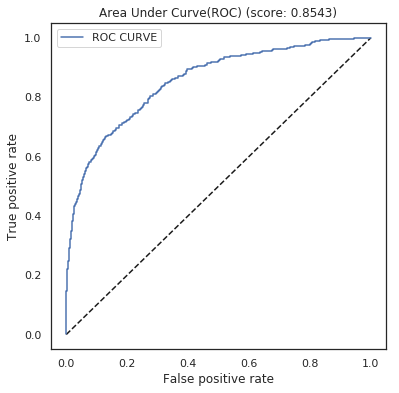

count    2500.000000
mean        0.192109
std         0.250828
min         0.003923
25%         0.031297
50%         0.081854
75%         0.233370
max         0.999838
dtype: float64
0.19210915 0.2508279


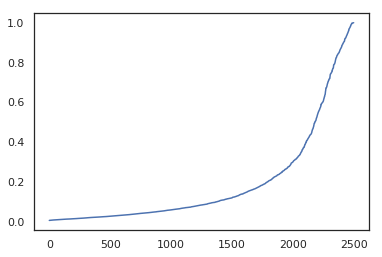

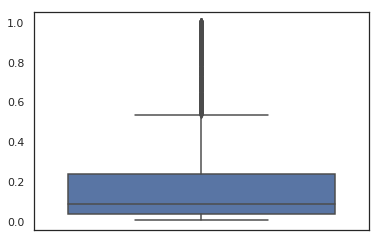

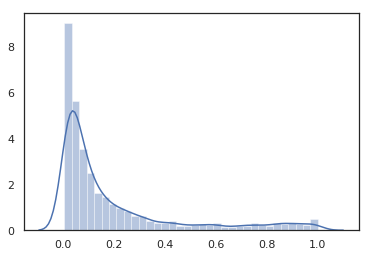

thres: 0.5874, f_beta score: 0.6823
accuracy@0.5874: 0.87

threshold@0.5, accuracy: 0.8624
[[1924   87]
 [ 257  232]] 

threshold@0.5874, accuracy: 0.8676
[[1956   55]
 [ 276  213]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Add Polynomial Featue Engineering

* Add quradratic, cube term base on numeric features

In [0]:
def do_nth_order_polynominal(num_features, data):
    for num_col in num_features:
        data[f'{num_col}_degree_2'] = data[num_col] ** 2
        data[f'{num_col}_degree_3'] = data[num_col] ** 3
    pass

In [24]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(7500, 71) (2500, 71)


,Gender_Female,HasCrCard_0,IsActiveMember_0,Geography_France,Geography_Germany,Geography_Spain,binn_Age_14-30,binn_Age_30-35,binn_Age_35-40,binn_Age_40-45,...,Age_degree_2,Age_degree_3,Tenure_degree_2,Tenure_degree_3,Balance_degree_2,Balance_degree_3,NumOfProducts_degree_2,NumOfProducts_degree_3,EstimatedSalary_degree_2,EstimatedSalary_degree_3
0,0,1,0,0,1,0,0,0,1,0,...,0.081876,-0.023428,2.982148,-5.149841e+00,0.670681,0.549255,0.646741,0.520110,0.202451,-0.091092
1,0,1,1,1,0,0,0,0,0,0,...,0.579956,0.441665,2.982148,-5.149841e+00,1.495981,-1.829740,0.834827,-0.762772,2.661079,-4.340968
2,1,1,1,1,0,0,0,0,0,0,...,9.876301,31.037837,1.074413,-1.113671e+00,1.495981,-1.829740,0.646741,0.520110,0.260524,-0.132975
3,1,1,0,1,0,0,0,0,0,1,...,0.144834,0.055120,0.475187,3.275649e-01,1.495981,-1.829740,0.646741,0.520110,1.092956,-1.142625
4,1,1,0,0,1,0,0,0,0,1,...,0.008994,0.000853,0.000001,-1.038016e-09,0.257468,0.130643,0.646741,0.520110,0.768690,-0.673949


## Model (WOE + Binning + Freqency Encoding + Target Mean Encoding + Polynominal)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 7,233
Trainable params: 7,233
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 58us/step - loss: 0.5567 - acc: 0.7993 - val_loss: 0.3875 - val_acc: 0.8320
Epoch 2/30
7500/7500 [==============================] - 0s 21us/step - loss: 0.3815 - acc

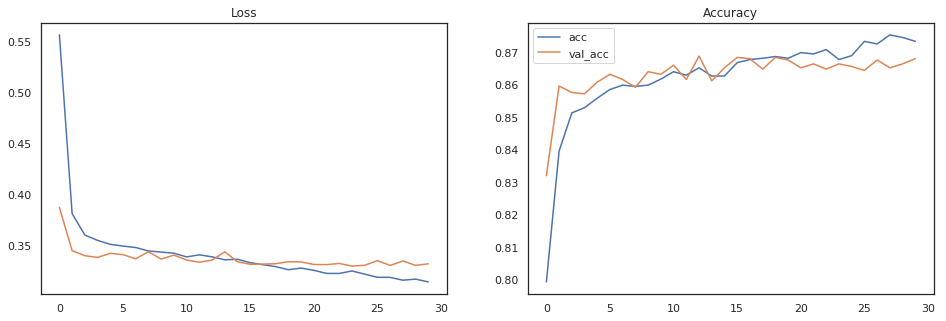

auc: 0.8553070586213454


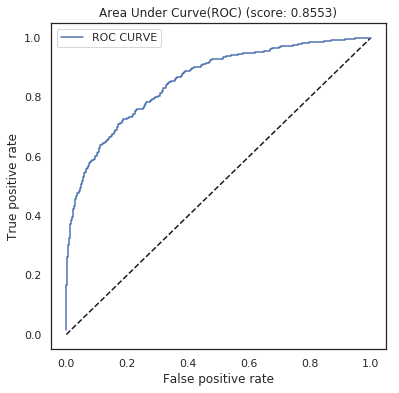

count    2500.000000
mean        0.191279
std         0.245841
min         0.001484
25%         0.033669
50%         0.092506
75%         0.230292
max         1.000000
dtype: float64
0.19127855 0.24584094


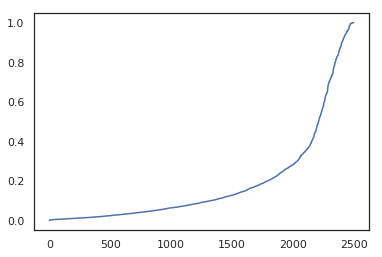

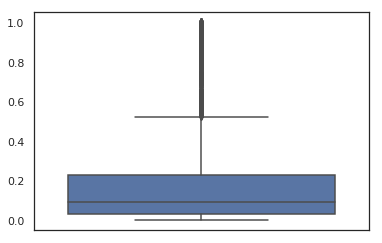

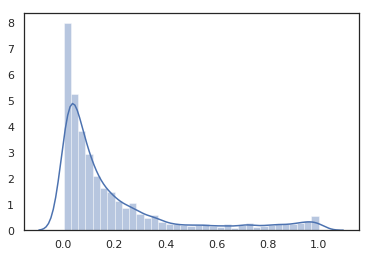

thres: 0.5764, f_beta score: 0.6899
accuracy@0.5764: 0.87

threshold@0.5, accuracy: 0.8680
[[1946   65]
 [ 265  224]] 

threshold@0.5764, accuracy: 0.8688
[[1966   45]
 [ 283  206]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x.shape[1])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x))

y_pred = model.predict(vl_x)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## PCA

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
tr_x_pca = pca.fit_transform(tr_x)
vl_x_pca = pca.transform(vl_x)

In [29]:
tr_x_pca.shape, vl_x_pca.shape

((7500, 64), (2500, 64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 66us/step - loss: 0.5620 - acc: 0.7951 - val_loss: 0.3844 - val_acc: 0.8100
Epoch 2/30
7500/7500 [==============================] - 0s 25us/step - loss: 0.3800 - acc

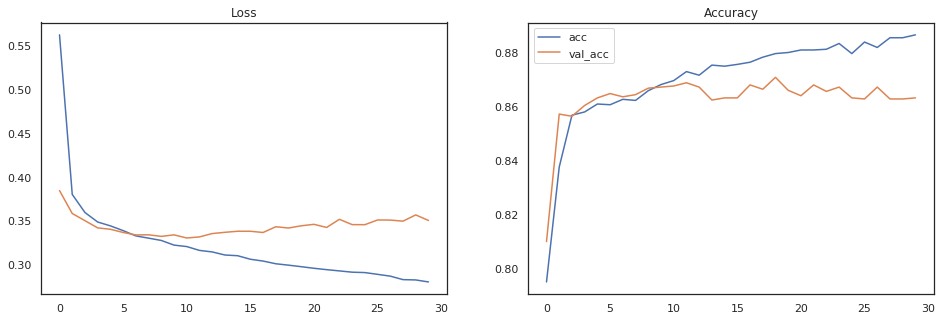

auc: 0.8452915915430368


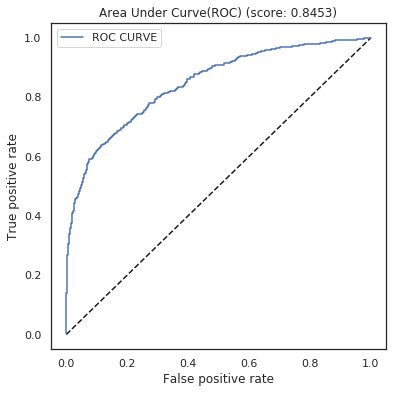

count    2500.000000
mean        0.186959
std         0.268826
min         0.000024
25%         0.019609
50%         0.062250
75%         0.219288
max         1.000000
dtype: float64
0.18695854 0.26882556


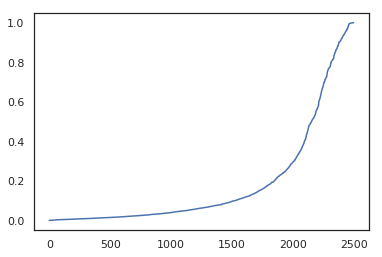

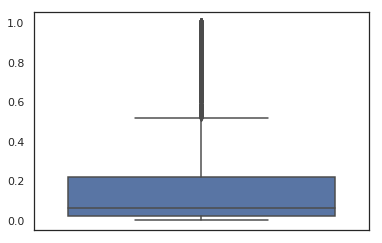

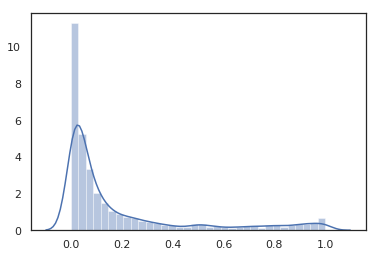

thres: 0.6465, f_beta score: 0.6922
accuracy@0.6465: 0.87

threshold@0.5, accuracy: 0.8632
[[1911  100]
 [ 242  247]] 

threshold@0.6465, accuracy: 0.8700
[[1960   51]
 [ 274  215]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x_pca.shape[1])
hist = model.fit(tr_x_pca, tr_y, validation_data=(vl_x_pca, vl_y), batch_size=100, epochs=30)
plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x_pca))

y_pred = model.predict(vl_x_pca)
pred_dist(y_pred)
analyze(vl_y, y_pred)

## Model (AutoEncoder)

In [31]:
# Trnasform raw data to foramt model recognized
tr_x, tr_y, status = feature_engineering(raw, is_train=True)
vl_x, vl_y, _ = feature_engineering(raw_vl, is_train=False, status=status)

print( tr_x.shape, vl_x.shape )
tr_x.head()

(7500, 71) (2500, 71)


,Gender_Female,HasCrCard_0,IsActiveMember_0,Geography_France,Geography_Germany,Geography_Spain,binn_Age_14-30,binn_Age_30-35,binn_Age_35-40,binn_Age_40-45,...,Age_degree_2,Age_degree_3,Tenure_degree_2,Tenure_degree_3,Balance_degree_2,Balance_degree_3,NumOfProducts_degree_2,NumOfProducts_degree_3,EstimatedSalary_degree_2,EstimatedSalary_degree_3
0,0,1,0,0,1,0,0,0,1,0,...,0.081876,-0.023428,2.982148,-5.149841e+00,0.670681,0.549255,0.646741,0.520110,0.202451,-0.091092
1,0,1,1,1,0,0,0,0,0,0,...,0.579956,0.441665,2.982148,-5.149841e+00,1.495981,-1.829740,0.834827,-0.762772,2.661079,-4.340968
2,1,1,1,1,0,0,0,0,0,0,...,9.876301,31.037837,1.074413,-1.113671e+00,1.495981,-1.829740,0.646741,0.520110,0.260524,-0.132975
3,1,1,0,1,0,0,0,0,0,1,...,0.144834,0.055120,0.475187,3.275649e-01,1.495981,-1.829740,0.646741,0.520110,1.092956,-1.142625
4,1,1,0,0,1,0,0,0,0,1,...,0.008994,0.000853,0.000001,-1.038016e-09,0.257468,0.130643,0.646741,0.520110,0.768690,-0.673949


Train on 7500 samples, validate on 2500 samples
Epoch 1/100
7500/7500 [==============================] - 1s 107us/step - loss: 0.9965 - val_loss: 0.2693
Epoch 2/100
7500/7500 [==============================] - 0s 44us/step - loss: 0.2024 - val_loss: 0.1366
Epoch 3/100
7500/7500 [==============================] - 0s 46us/step - loss: 0.1212 - val_loss: 0.0977
Epoch 4/100
7500/7500 [==============================] - 0s 45us/step - loss: 0.0897 - val_loss: 0.0761
Epoch 5/100
7500/7500 [==============================] - 0s 44us/step - loss: 0.0716 - val_loss: 0.0633
Epoch 6/100
7500/7500 [==============================] - 0s 45us/step - loss: 0.0598 - val_loss: 0.0556
Epoch 7/100
7500/7500 [==============================] - 0s 45us/step - loss: 0.0528 - val_loss: 0.0480
Epoch 8/100
7500/7500 [==============================] - 0s 44us/step - loss: 0.0454 - val_loss: 0.0421
Epoch 9/100
7500/7500 [==============================] - 0s 45us/step - loss: 0.0421 - val_loss: 0.0395
Epoch 10/100
75

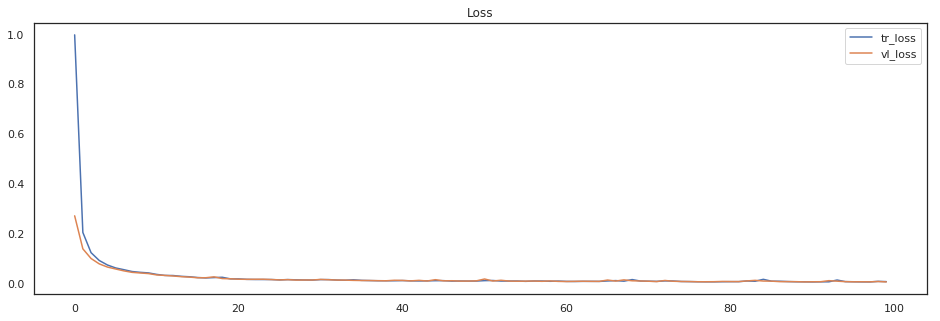

In [38]:
K.clear_session()

inputs_dim = tr_x.shape[1]

inputs = Input(shape=(inputs_dim, ))
# Encoder
encoded = Dense(inputs_dim, activation='selu')(inputs)
encoded = Dense(128, activation='selu')(encoded)
encoded = Dense(64, activation='selu')(encoded)
encoded = Dense(64, activation='selu')(encoded)

# Decoder
decoded = Dense(64, activation='selu')(encoded)
decoded = Dense(64, activation='selu')(decoded)
decoded = Dense(128, activation='selu')(decoded)
decoded = Dense(inputs_dim, activation='linear')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs, decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs, encoded)

# Adam Optimizer + Mean square error loss
autoencoder.compile(optimizer='adam', loss='mse')
hist = autoencoder.fit(
    tr_x, tr_x, 
    epochs=100, 
    batch_size=200, 
    shuffle=True, 
    validation_data=(vl_x, vl_x))

def plot_ae(hist):
    plt.figure(figsize=(16, 5))
    plt.plot(hist.history['loss'], label='tr_loss')
    plt.plot(hist.history['val_loss'], label='vl_loss')
    plt.title('Loss')
    plt.legend(loc='best')
    plt.show()
    
plot_ae(hist)

In [0]:
tr_x_ae = encoder.predict(tr_x)
vl_x_ae = encoder.predict(vl_x)

In [40]:
tr_x_ae.shape, vl_x_ae.shape

((7500, 64), (2500, 64))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 0s 58us/step - loss: 0.5606 - acc: 0.7860 - val_loss: 0.4702 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.4478 - acc

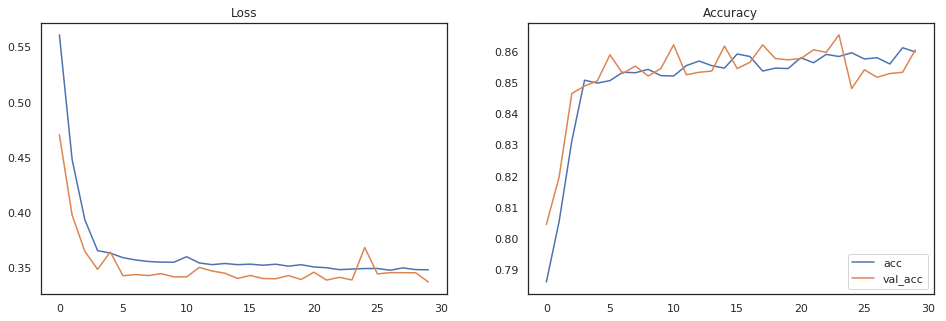

auc: 0.8572595103210462


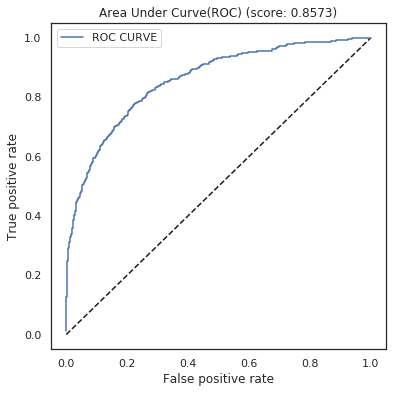

count    2500.000000
mean        0.200234
std         0.248085
min         0.005554
25%         0.037369
50%         0.093125
75%         0.237317
max         1.000000
dtype: float64
0.2002339 0.2480848


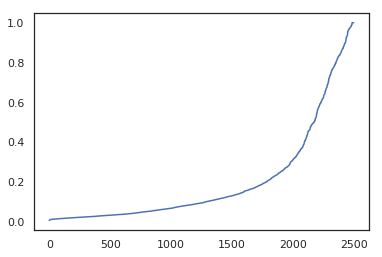

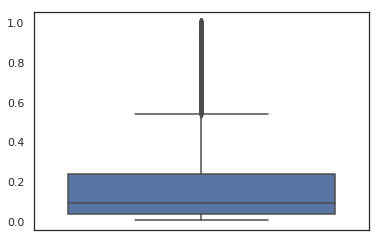

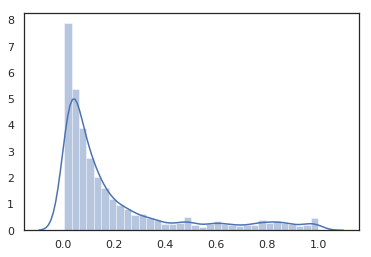

thres: 0.5781, f_beta score: 0.6691
accuracy@0.5781: 0.86

threshold@0.5, accuracy: 0.8604
[[1918   93]
 [ 256  233]] 

threshold@0.5781, accuracy: 0.8648
[[1944   67]
 [ 271  218]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
def get_model(input_dim):
    model = Sequential()
    # kernel_regularizer=regularizers.l2(0.005)
    model.add(Dense(units = 64, activation = 'relu', kernel_initializer='uniform', input_dim = input_dim))
    model.add(Dense(units = 32, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 16, activation = 'relu', kernel_initializer='uniform'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='uniform'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

K.clear_session()

model = get_model(input_dim=tr_x_ae.shape[1])
hist = model.fit(tr_x_ae, tr_y, validation_data=(vl_x_ae, vl_y), batch_size=100, epochs=30)

plot_result(hist)
draw_roc_curve(vl_y, model.predict(vl_x_ae))

y_pred = model.predict(vl_x_ae)
pred_dist(y_pred)
analyze(vl_y, y_pred)